# Concentration de CO2 dans l'atmosphère depuis 1958

In [14]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack,signal
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

Les données de l'incidence de la varicelle sont disponibles du site Web de [l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1958 et se termine avec une semaine récente.

Pour nous protéger contre une éventuelle disparition ou modification du serveur du Réseau Sentinelles, nous faisons une copie locale de ce jeux de données.

Il est inutile et même risquée de télécharger les données à chaque exécution, car dans le cas d'une panne nous pourrions remplacer nos données par un fichier défectueux. Pour cette raison, nous téléchargeons les données seulement si la copie locale n'existe pas.

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
file_name = "weekly_in_situ_co2_mlo.csv"
    
if os.path.isfile(file_name):
    raw_data = pd.read_csv(file_name)
    raw_data = raw_data.set_index('Time').sort_index()
    print("Data imported via the local file.")
else:
    raw_data = pd.read_csv(data_url, skiprows=43)
    print("Data downloaded via the url.")
    raw_data.index.name = 'Time'
    raw_data = raw_data.rename(columns={raw_data.columns[0]: 'CO2_concentration'}).sort_index()
    raw_data.to_csv(file_name)
    print("Data saved locally.")
    
raw_data

Data imported via the local file.


CO2_concentration
Time                         
1958-03-29             316.19
1958-04-05             317.31
1958-04-12             317.69
1958-04-19             317.58
1958-04-26             316.48
1958-05-03             316.95
1958-05-17             317.56
1958-05-24             317.99
1958-07-05             315.85
1958-07-12             315.85
1958-07-19             315.46
1958-07-26             315.59
1958-08-02             315.64
1958-08-09             315.10
1958-08-16             315.09
1958-08-30             314.14
1958-09-06             313.54
1958-11-08             313.05
1958-11-15             313.26
1958-11-22             313.57
1958-11-29             314.01
1958-12-06             314.56
1958-12-13             314.41
1958-12-20             314.77
1958-12-27             315.21
1959-01-03             315.24
1959-01-10             315.50
1959-01-17             315.69
1959-01-24             315.86
1959-01-31             315.42
...                       ...
2021-02-06             416.91
2021-02-13             416.46
2021-02-20             416.16
2021-02-27             416.45
2021-03-06             417.56
2021-03-13             416.54
2021-03-20             418.00
2021-03-27             416.43
2021-04-03             417.69
2021-04-10             419.02
2021-04-17             417.66
2021-04-24             418.54
2021-05-01             419.65
2021-05-08             418.16
2021-05-15             419.02
2021-05-22             417.98
2021-05-29             419.49
2021-06-05             419.46
2021-06-12             418.90
2021-06-19             418.49
2021-06-26             417.82
2021-07-03             417.70
2021-07-10             417.08
2021-07-17             416.91
2021-07-24             415.92
2021-07-31             414.94
2021-08-07             414.56
2021-08-14             414.66
2021-08-21             414.42
2021-08-28             412.68

[3238 rows x 1 columns]

## Analyse de la courbe : tendance et saisonnalité

On transforme l'index en Time series avec une fréquence hebdomadaire.

In [3]:
raw_data.index = pd.to_datetime(raw_data.index)
data=raw_data.sort_index().asfreq('W-Sat')
data.shape

(3310, 1)

Malheureusement, des valeurs NaN se trouvent dans la table: il doit d'agir de semaines où les concentrations de C02 n'ont pas pu être enregistrées pour diverses raisons.

In [4]:
data[data.isnull().any(axis=1)].shape

(72, 1)

Comme ces "mauvaises semaines" sont minoritaires (72 semaines sur 3310). Je remplace ces NaN avec des valeurs obtenues par interpolation linéaire.

In [5]:
data=data.interpolate(method='linear')
data

CO2_concentration
Time                         
1958-03-29         316.190000
1958-04-05         317.310000
1958-04-12         317.690000
1958-04-19         317.580000
1958-04-26         316.480000
1958-05-03         316.950000
1958-05-10         317.255000
1958-05-17         317.560000
1958-05-24         317.990000
1958-05-31         317.633333
1958-06-07         317.276667
1958-06-14         316.920000
1958-06-21         316.563333
1958-06-28         316.206667
1958-07-05         315.850000
1958-07-12         315.850000
1958-07-19         315.460000
1958-07-26         315.590000
1958-08-02         315.640000
1958-08-09         315.100000
1958-08-16         315.090000
1958-08-23         314.615000
1958-08-30         314.140000
1958-09-06         313.540000
1958-09-13         313.485556
1958-09-20         313.431111
1958-09-27         313.376667
1958-10-04         313.322222
1958-10-11         313.267778
1958-10-18         313.213333
...                       ...
2021-02-06         416.910000
2021-02-13         416.460000
2021-02-20         416.160000
2021-02-27         416.450000
2021-03-06         417.560000
2021-03-13         416.540000
2021-03-20         418.000000
2021-03-27         416.430000
2021-04-03         417.690000
2021-04-10         419.020000
2021-04-17         417.660000
2021-04-24         418.540000
2021-05-01         419.650000
2021-05-08         418.160000
2021-05-15         419.020000
2021-05-22         417.980000
2021-05-29         419.490000
2021-06-05         419.460000
2021-06-12         418.900000
2021-06-19         418.490000
2021-06-26         417.820000
2021-07-03         417.700000
2021-07-10         417.080000
2021-07-17         416.910000
2021-07-24         415.920000
2021-07-31         414.940000
2021-08-07         414.560000
2021-08-14         414.660000
2021-08-21         414.420000
2021-08-28         412.680000

[3310 rows x 1 columns]

Nous affichons l'incidence en fonction du temps. On peut voir que cette courbe à une tendance croissante.

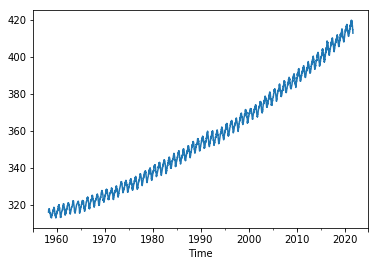

In [6]:
data['CO2_concentration'].plot()

Un zoom sur les dernières années montre une saisonalité d'environ 1 ans.

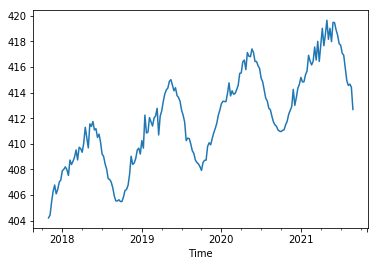

In [7]:
data['CO2_concentration'][-200:].plot()

Vérifions tous cela. On va décomposer cette courbe via la fonction [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). La tendance et la saisonalité semble s'additionner. Pour la saisonalité, on calculera la fréquence et l'amplitude de la courbe avec une [Transformation de Fourier](https://fr.wikipedia.org/wiki/Transformation_de_Fourier). Pour la tendance, on utilisera une [régression polynomiale](https://fr.wikipedia.org/wiki/R%C3%A9gression_polynomiale).

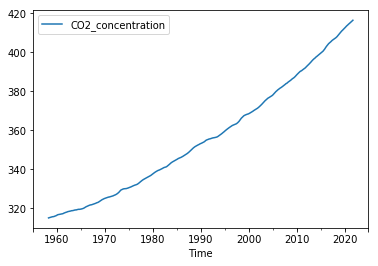

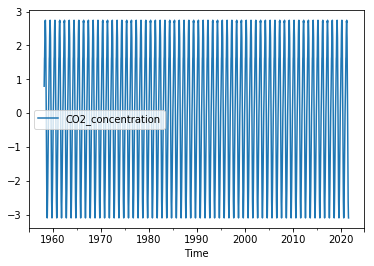

In [8]:
result = seasonal_decompose(data, model="additive",extrapolate_trend="freq")
result.trend.plot()
result.seasonal.plot()

### Transformée de Foruier de la saisonalité

Nous réalisons la tranformée de Fourier de la courbe de saisonalité.

Text(0,0.5,'power')

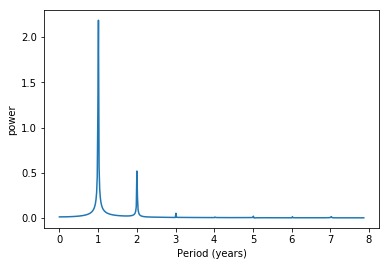

In [9]:
season=result.seasonal

# Number of samplepoints
N = season.shape[0]
# sample spacing
weeks_by_years=365/7

season_fft = fftpack.fft(season["CO2_concentration"])
amplitude_fft = 2.0/N * np.abs(season_fft)
peak = signal.find_peaks(amplitude_fft)

xf = np.linspace(0.0, 1.0/(2.0*(1/weeks_by_years)), int(N/2))
plt.plot(xf[0:500], 2.0/N * np.abs(season_fft[0:500]))
plt.xlabel('Period (years)')
plt.ylabel('power')

L'affichage de la transformée de Fourier montre 2 composantes principales à ces oscillations de période de 1 et 2 ans et d'amplitude 2.18 et 0.52 umol/mol respectivement.

In [10]:
print("main_frequency:",xf[peak[0][0]],", main_frequency_amplitude:",amplitude_fft[peak[0][0]])
print("second_frequency:",xf[peak[0][1]],", second_frequency_amplitude:",amplitude_fft[peak[0][1]])

main_frequency: 1.0088098117118676 , main_frequency_amplitude: 2.184959157879391
second_frequency: 2.001856970115737 , second_frequency_amplitude: 0.5192038125798919


## Modèle de tendance

La tendance semble être une fonction polynomiale d'ordre 2. Nous réaliserons une régression polynomiale d'ordre 2.

0.9994858695079444
[ 0.00000000e+00 -5.14361913e+01  1.33241982e-02]


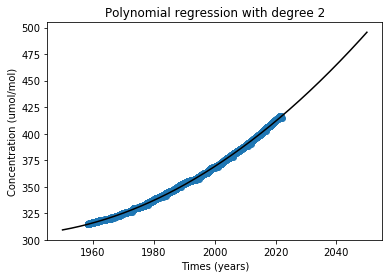

In [22]:
trend=result.trend

degree=2
polynomial_features = PolynomialFeatures(degree = degree)

model_trend=LinearRegression()

x=np.expand_dims(np.array(trend.index.year.astype(float)+trend.index.week.astype(float)/53),axis=-1)
y=np.array(trend["CO2_concentration"])

X_TRANSF = polynomial_features.fit_transform(x)
model_trend.fit(X_TRANSF,y)
Y_NEW = model_trend.predict(X_TRANSF)
print(r2_score(y, Y_NEW))
print(model_trend.coef_)

X_seq = np.linspace(1950,2050,2000).reshape(-1,1)

plt.figure()
plt.scatter(x,y)
plt.plot(X_seq,model_trend.predict(polynomial_features.fit_transform(X_seq)),color="black")
plt.title("Polynomial regression with degree "+str(degree))
plt.xlabel('Times (years)')
plt.ylabel('Concentration (umol/mol)')
plt.show()

La régression semble fonctionelle. Prenons ces coefficients.

In [37]:
print("polynomial coef:",model_trend.coef_)
print("constant coef:", model_trend.intercept_)

polynomial coef: [ 0.00000000e+00 -5.14361913e+01  1.33241982e-02]
constant coef: 49944.79903461095


On obtient la concentration en C02 en fonction du temps avec la fonction : $f(T) = 49944.8 - 51.44 * T + 0.0133 * T^2$ .

En 2025, la concentration en CO2 devrait être de 424 umol/mol.

In [41]:
X_TRANSF = polynomial_features.fit_transform([[2025]])
model_trend.predict(X_TRANSF)

[[1.000000e+00 2.025000e+03 4.100625e+06]]


array([424.05170121])